In [35]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from dl_biology.cafa6.training import generate_dataloader
from dl_biology.cafa6.helper import get_csr_matrix_from_terms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from dl_biology.cafa6.vanilla_models import NeuralNet
from dl_biology.cafa6.loss import FocalLoss
import matplotlib.pyplot as plt
from dl_biology.cafa6.training import calculate_fmax

import torch.nn as nn
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# filepaths to fasta
path_to_hidden_embedding = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/cafa-6-protein-function-prediction/train_hidden_states/esm2_t6_8M_UR50D.h5"

# filepath to GO terms
path_to_go_term_train = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/cafa-6-protein-function-prediction/Train/train_terms.tsv"
path_term_weights = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/cafa-6-protein-function-prediction/IA.tsv"
term_weights = pd.read_csv(path_term_weights, delimiter="\t", header=None)


In [37]:
def collate_fn(batch):
    # batch is a list of dicts
    embeds = [item["embedding"] for item in batch]
    seq_lengths = [item["seq_len"] for item in batch]
    labels = [item["label"] for item in batch]

    embeds_padded = pad_sequence(embeds, padding_value=0, batch_first=True)
    seq_lengths = torch.tensor(seq_lengths)
    labels = torch.stack(labels) if isinstance(labels[0], torch.Tensor) else torch.tensor(labels)
    max_len = embeds_padded.size(1)
    attention_mask = torch.arange(max_len).unsqueeze(0) < seq_lengths.unsqueeze(-1)
    
    return {
        "embedding": embeds_padded,
        "label": labels,
        "attn_mask": attention_mask
    }

In [41]:
# create train and val dataloader
train_terms = pd.read_csv(path_to_go_term_train, delimiter="\t")

train_terms_C = train_terms[train_terms["aspect"] == "C"]
train_terms_F = train_terms[train_terms["aspect"] == "F"]
train_terms_P = train_terms[train_terms["aspect"] == "P"]

seq_ids_C = (train_terms_C["EntryID"].unique())
label_data_C, entry_labels_C, term_labels_C = get_csr_matrix_from_terms(train_terms_C)
label_data_F, entry_labels_F, term_labels_F = get_csr_matrix_from_terms(train_terms_F)
label_data_P, entry_labels_P, term_labels_P = get_csr_matrix_from_terms(train_terms_P)

train_idx_C, val_idx_C = train_test_split(
    np.arange(len(seq_ids_C)),
    test_size=0.1,
    random_state=42,
    shuffle=True
)

train_seq_ids_C = [seq_ids_C[idx] for idx in train_idx_C]
val_seq_ids_C = [seq_ids_C[idx] for idx in val_idx_C]

train_dataloader_C, val_dataloader_C = generate_dataloader(label_data_C, entry_labels_C, path_to_hidden_embedding, train_seq_ids_C, val_seq_ids_C, collate_fn, batch_size=32)

In [44]:
n_epochs = 50
embedding_size = 320
dropout = 0.1
out_dim = 2651
ia_weight = torch.tensor(term_weights.set_index(0).loc[term_labels_C, 1].values, dtype=torch.float32)
model = NeuralNet(embedding_size=embedding_size, dropout=dropout, out_dim=out_dim)

100%|██████████| 189/189 [00:24<00:00,  7.77it/s]


Epoch 0 ===== train loss: 0.004059060642419972
Epoch 0 ===== val loss: 0.003516490946316885 ===== val f1: 0.17298351614676824


100%|██████████| 189/189 [00:24<00:00,  7.77it/s]


Epoch 1 ===== train loss: 0.0034905775190157517
Epoch 1 ===== val loss: 0.003189213612737755 ===== val f1: 0.22703261046455664


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 2 ===== train loss: 0.0031192660519665434
Epoch 2 ===== val loss: 0.0028354095063472867 ===== val f1: 0.232028527788454


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 3 ===== train loss: 0.0027820362014402767
Epoch 3 ===== val loss: 0.0027426209771345376 ===== val f1: 0.2405634769660728


100%|██████████| 189/189 [00:24<00:00,  7.71it/s]


Epoch 4 ===== train loss: 0.00264546386927766
Epoch 4 ===== val loss: 0.0026534810895100236 ===== val f1: 0.2388579576845582


100%|██████████| 189/189 [00:24<00:00,  7.79it/s]


Epoch 5 ===== train loss: 0.0026215510922997535
Epoch 5 ===== val loss: 0.0026067700772915803 ===== val f1: 0.2504190431468597


100%|██████████| 189/189 [00:24<00:00,  7.72it/s]


Epoch 6 ===== train loss: 0.00254732196669963
Epoch 6 ===== val loss: 0.0025884586739940226 ===== val f1: 0.24713192336097178


100%|██████████| 189/189 [00:24<00:00,  7.78it/s]


Epoch 7 ===== train loss: 0.00253109244995186
Epoch 7 ===== val loss: 0.002544668306616288 ===== val f1: 0.2549544974181538


100%|██████████| 189/189 [00:24<00:00,  7.67it/s]


Epoch 8 ===== train loss: 0.0024774033273680064
Epoch 8 ===== val loss: 0.0026694341481382413 ===== val f1: 0.23556248858142062


100%|██████████| 189/189 [00:24<00:00,  7.66it/s]


Epoch 9 ===== train loss: 0.0024660217338848423
Epoch 9 ===== val loss: 0.002485902874025876 ===== val f1: 0.25553802690805827


100%|██████████| 189/189 [00:24<00:00,  7.63it/s]


Epoch 10 ===== train loss: 0.0024123791060772864
Epoch 10 ===== val loss: 0.0024853782677806166 ===== val f1: 0.2560153239795672


100%|██████████| 189/189 [00:24<00:00,  7.64it/s]


Epoch 11 ===== train loss: 0.002401438774884226
Epoch 11 ===== val loss: 0.0024737041411556737 ===== val f1: 0.2615157025965941


100%|██████████| 189/189 [00:24<00:00,  7.64it/s]


Epoch 12 ===== train loss: 0.0023848276817622013
Epoch 12 ===== val loss: 0.002464703164708914 ===== val f1: 0.2640993330557482


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 13 ===== train loss: 0.0023757664486834503
Epoch 13 ===== val loss: 0.002507643495740556 ===== val f1: 0.2562921776214065


100%|██████████| 189/189 [00:24<00:00,  7.71it/s]


Epoch 14 ===== train loss: 0.0023604430040201274
Epoch 14 ===== val loss: 0.002438952491579272 ===== val f1: 0.2665190889796864


100%|██████████| 189/189 [00:24<00:00,  7.67it/s]


Epoch 15 ===== train loss: 0.002541679755250818
Epoch 15 ===== val loss: 0.0033743516585134246 ===== val f1: 0.19615951971382903


100%|██████████| 189/189 [00:24<00:00,  7.69it/s]


Epoch 16 ===== train loss: 0.0026264707875665373
Epoch 16 ===== val loss: 0.0025230825720995507 ===== val f1: 0.2507826659564479


100%|██████████| 189/189 [00:24<00:00,  7.76it/s]


Epoch 17 ===== train loss: 0.0024260609213497273
Epoch 17 ===== val loss: 0.002536527130003802 ===== val f1: 0.24818095919691235


100%|██████████| 189/189 [00:24<00:00,  7.65it/s]


Epoch 18 ===== train loss: 0.002376969686492713
Epoch 18 ===== val loss: 0.002496566648087489 ===== val f1: 0.2455541474681596


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 19 ===== train loss: 0.002360809870192755
Epoch 19 ===== val loss: 0.0024804029405540813 ===== val f1: 0.25474471241800273


100%|██████████| 189/189 [00:24<00:00,  7.69it/s]


Epoch 20 ===== train loss: 0.0023620225635551046
Epoch 20 ===== val loss: 0.0024551309395098577 ===== val f1: 0.25599438521672946


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 21 ===== train loss: 0.0023735195833446683
Epoch 21 ===== val loss: 0.0025039973789481103 ===== val f1: 0.2596029903001183


100%|██████████| 189/189 [00:24<00:00,  7.74it/s]


Epoch 22 ===== train loss: 0.0023176739355307598
Epoch 22 ===== val loss: 0.0024347233163468816 ===== val f1: 0.2686375584206117


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 23 ===== train loss: 0.0022984571677505234
Epoch 23 ===== val loss: 0.002438028299905084 ===== val f1: 0.26476389720134624


100%|██████████| 189/189 [00:24<00:00,  7.64it/s]


Epoch 24 ===== train loss: 0.0022842095162525096
Epoch 24 ===== val loss: 0.002432840551057505 ===== val f1: 0.27048511592909036


100%|██████████| 189/189 [00:24<00:00,  7.66it/s]


Epoch 25 ===== train loss: 0.002291734697311493
Epoch 25 ===== val loss: 0.002440766203488228 ===== val f1: 0.263006277419984


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 26 ===== train loss: 0.002287558583668455
Epoch 26 ===== val loss: 0.0025006206262679328 ===== val f1: 0.23919442897120646


100%|██████████| 189/189 [00:24<00:00,  7.74it/s]


Epoch 27 ===== train loss: 0.0023895756201214543
Epoch 27 ===== val loss: 0.00243874855287787 ===== val f1: 0.26271038178256095


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 28 ===== train loss: 0.0023628266501547397
Epoch 28 ===== val loss: 0.0024262864602158075 ===== val f1: 0.2656863554477248


100%|██████████| 189/189 [00:24<00:00,  7.68it/s]


Epoch 29 ===== train loss: 0.002332692098962242
Epoch 29 ===== val loss: 0.0024297868533592138 ===== val f1: 0.2625165500438554


100%|██████████| 189/189 [00:24<00:00,  7.59it/s]


Epoch 30 ===== train loss: 0.002273683579880766
Epoch 30 ===== val loss: 0.002404527267485502 ===== val f1: 0.27051418729419213


100%|██████████| 189/189 [00:24<00:00,  7.68it/s]


Epoch 31 ===== train loss: 0.002266080207537359
Epoch 31 ===== val loss: 0.002395469703337069 ===== val f1: 0.2739299565222541


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 32 ===== train loss: 0.0022363990550695475
Epoch 32 ===== val loss: 0.0023759600894880436 ===== val f1: 0.26999562741558303


100%|██████████| 189/189 [00:24<00:00,  7.69it/s]


Epoch 33 ===== train loss: 0.002222874323294645
Epoch 33 ===== val loss: 0.0024037850397348247 ===== val f1: 0.2706036141688816


100%|██████████| 189/189 [00:24<00:00,  7.75it/s]


Epoch 34 ===== train loss: 0.0022074285420528197
Epoch 34 ===== val loss: 0.002398691427765818 ===== val f1: 0.2729265642121796


100%|██████████| 189/189 [00:24<00:00,  7.67it/s]


Epoch 35 ===== train loss: 0.002245249863404271
Epoch 35 ===== val loss: 0.002416692242376191 ===== val f1: 0.26779070318762005


100%|██████████| 189/189 [00:24<00:00,  7.71it/s]


Epoch 36 ===== train loss: 0.003732718959618755
Epoch 36 ===== val loss: 0.0027478438686264098 ===== val f1: 0.24826158133190865


100%|██████████| 189/189 [00:24<00:00,  7.74it/s]


Epoch 37 ===== train loss: 0.0024613742354871785
Epoch 37 ===== val loss: 0.002517693098289547 ===== val f1: 0.2465179196100057


100%|██████████| 189/189 [00:24<00:00,  7.72it/s]


Epoch 38 ===== train loss: 0.0023236671069821998
Epoch 38 ===== val loss: 0.002441585010346321 ===== val f1: 0.25712347550837006


100%|██████████| 189/189 [00:24<00:00,  7.66it/s]


Epoch 39 ===== train loss: 0.002305113907943519
Epoch 39 ===== val loss: 0.0024394833756285527 ===== val f1: 0.26054704575504634


100%|██████████| 189/189 [00:24<00:00,  7.67it/s]


Epoch 40 ===== train loss: 0.002328530791584064
Epoch 40 ===== val loss: 0.0023807142497774547 ===== val f1: 0.26745561843327115


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 41 ===== train loss: 0.00225438238223158
Epoch 41 ===== val loss: 0.0024070058858130503 ===== val f1: 0.27026119365383605


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 42 ===== train loss: 0.0022287414485274567
Epoch 42 ===== val loss: 0.0023523224517703056 ===== val f1: 0.27049871751476323


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 43 ===== train loss: 0.0022027194665737763
Epoch 43 ===== val loss: 0.002349345425572542 ===== val f1: 0.2754734508449387


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 44 ===== train loss: 0.00222318462061285
Epoch 44 ===== val loss: 0.0023724035373470062 ===== val f1: 0.27083371927453537


100%|██████████| 189/189 [00:25<00:00,  7.55it/s]


Epoch 45 ===== train loss: 0.0021823397763103647
Epoch 45 ===== val loss: 0.002343323624387344 ===== val f1: 0.2782550616245939


100%|██████████| 189/189 [00:24<00:00,  7.68it/s]


Epoch 46 ===== train loss: 0.0022346548309696854
Epoch 46 ===== val loss: 0.0023725899219729754 ===== val f1: 0.26988500094634327


100%|██████████| 189/189 [00:24<00:00,  7.69it/s]


Epoch 47 ===== train loss: 0.002466794799061663
Epoch 47 ===== val loss: 0.002754189927751819 ===== val f1: 0.23810170658158378


100%|██████████| 189/189 [00:24<00:00,  7.74it/s]


Epoch 48 ===== train loss: 0.002363575777259407
Epoch 48 ===== val loss: 0.002436373611941697 ===== val f1: 0.2599868042722051


100%|██████████| 189/189 [00:24<00:00,  7.65it/s]


Epoch 49 ===== train loss: 0.002272468648578001
Epoch 49 ===== val loss: 0.002411735747945766 ===== val f1: 0.2630058390750416


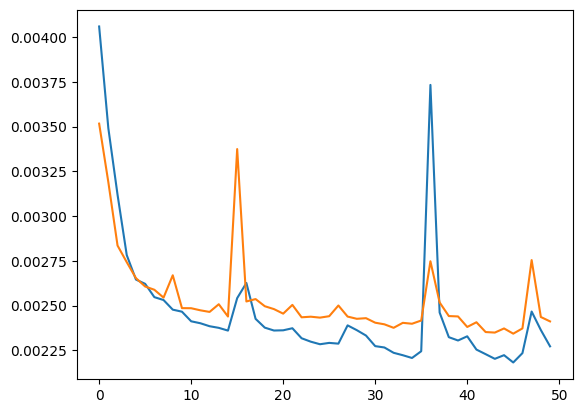

In [ ]:
lr = 0.001
criterion = FocalLoss(gamma=2, ia_weight=ia_weight)
# criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    prob_train = []
    label_train = []
    model.train()

    for batch in tqdm(train_dataloader_C):
        embedding = batch["embedding"]
        attn_mask = batch["attn_mask"]
        label = batch["label"]

        output = model(embedding, attn_mask)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        prob_train.append(torch.sigmoid(output).detach().numpy())
        label_train.append(label)
    
    train_loss /= len(train_dataloader_C)
    train_losses.append(train_loss)

    prob_val = []
    label_val = []
    model.eval()

    for batch in tqdm(val_dataloader_C):

        with torch.no_grad():
            embedding = batch["embedding"]
            attn_mask = batch["attn_mask"]
            label = batch["label"]

            output = model(embedding, attn_mask)
            loss = criterion(output, label)

            val_loss += loss.item()
            prob_val.append(torch.sigmoid(output).detach().numpy())
            label_val.append(label)

    y_pred_val = np.concatenate(prob_val)
    label_val = np.concatenate(label_val)
    f1_val, _, _ = calculate_fmax(y_pred_val,  label_val, ia_weight)
    val_loss /= len(val_dataloader_C)
    val_losses.append(val_loss)

    print(f"Epoch {epoch} ===== train loss: {train_loss}")
    print(f"Epoch {epoch} ===== val loss: {val_loss} ===== val f1: {f1_val}")

plt.plot([loss for loss in train_losses])
plt.plot([loss for loss in val_losses])


In [ ]:
import torch.nn.functional as F
class SafeWeightedBCELoss(nn.Module):
    def __init__(self, pos_weights=None, smoothing=0.0):
        super().__init__()
        self.smoothing = smoothing
        
        if pos_weights is not None:
            # Normalize and clip weights
            pos_weights = np.array(pos_weights)
            pos_weights = pos_weights / pos_weights.mean()
            pos_weights = np.clip(pos_weights, 0.5, 5.0)  # Prevent extreme weights
            self.pos_weights = torch.FloatTensor(pos_weights)
        else:
            self.pos_weights = None
    
    def forward(self, logits, targets):
        # Label smoothing
        if self.smoothing > 0:
            targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        
        # Weighted BCE
        if self.pos_weights is not None:
            pos_weights = self.pos_weights.to(logits.device)
            loss = F.binary_cross_entropy_with_logits(
                logits, targets,
                pos_weight=pos_weights,
                reduction='mean'
            )
        else:
            loss = F.binary_cross_entropy_with_logits(
                logits, targets,
                reduction='mean'
            )
        
        return loss

In [ ]:
outputs = []
for batch in tqdm(val_dataloader_C):

    with torch.no_grad():
        model.eval()
        embedding = batch["embedding"]
        attn_mask = batch["attn_mask"]
        label = batch["label"]

        output = model(embedding, attn_mask)
        output = torch.sigmoid(output).detach().numpy()
        outputs.append(output)

100%|██████████| 32/32 [00:03<00:00,  9.01it/s]
